## Анализ данных для обучения
Посмотрим, с какими данными придётся иметь дело.

In [8]:
import pandas as pd

import os

data_folder = 'data'
images_folder = 'images'
dish_df_name = 'dish.csv'
ingredients_df_name = 'ingredients.csv'

In [11]:
ingrs = pd.read_csv(os.path.join(data_folder, ingredients_df_name))
print(ingrs.shape)
ingrs.head()

(555, 2)


,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes


Всего возможных ингредиентов 555. Посмотрим, все ли они используются в данных для обучения.

In [12]:

dish_df = pd.read_csv(
    os.path.join(data_folder, dish_df_name), 
    converters={
        'ingredients': lambda x: x.split(';')
        })
dish_df.head(5)

,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,"[ingr_0000000508, ingr_0000000122, ingr_000000...",test
1,dish_1561662054,419.438782,292.0,"[ingr_0000000312, ingr_0000000026, ingr_000000...",train
2,dish_1562008979,382.936646,290.0,"[ingr_0000000448, ingr_0000000520, ingr_000000...",test
3,dish_1560455030,20.590000,103.0,"[ingr_0000000471, ingr_0000000031, ingr_000000...",train
4,dish_1558372433,74.360001,143.0,[ingr_0000000453],train


In [5]:
unique_ingredients = []
for _, row in dish_df.iterrows():
    unique_ingredients.extend(row['ingredients'])
unique_ingrs_n = len(set(unique_ingredients))
print(f'Использовано уникальных ингредиентов: {unique_ingrs_n}')

Использовано уникальных ингредиентов: 200


В данных для обучения используется 200 ингредиентов из имеющихся 500. 
Сначала я хотела использовать RNN-подобную архитектуру, считая один ингредиент за один токен.
Но раз в наборе данных для обучения представлен не весь набор возможных ингредиентов, то лучше использовать предобученный трансформер: таким образом у рецепта всегда будет более-менее значимый эмбеддинг.


Теперь посмотрим на образцы изображений.

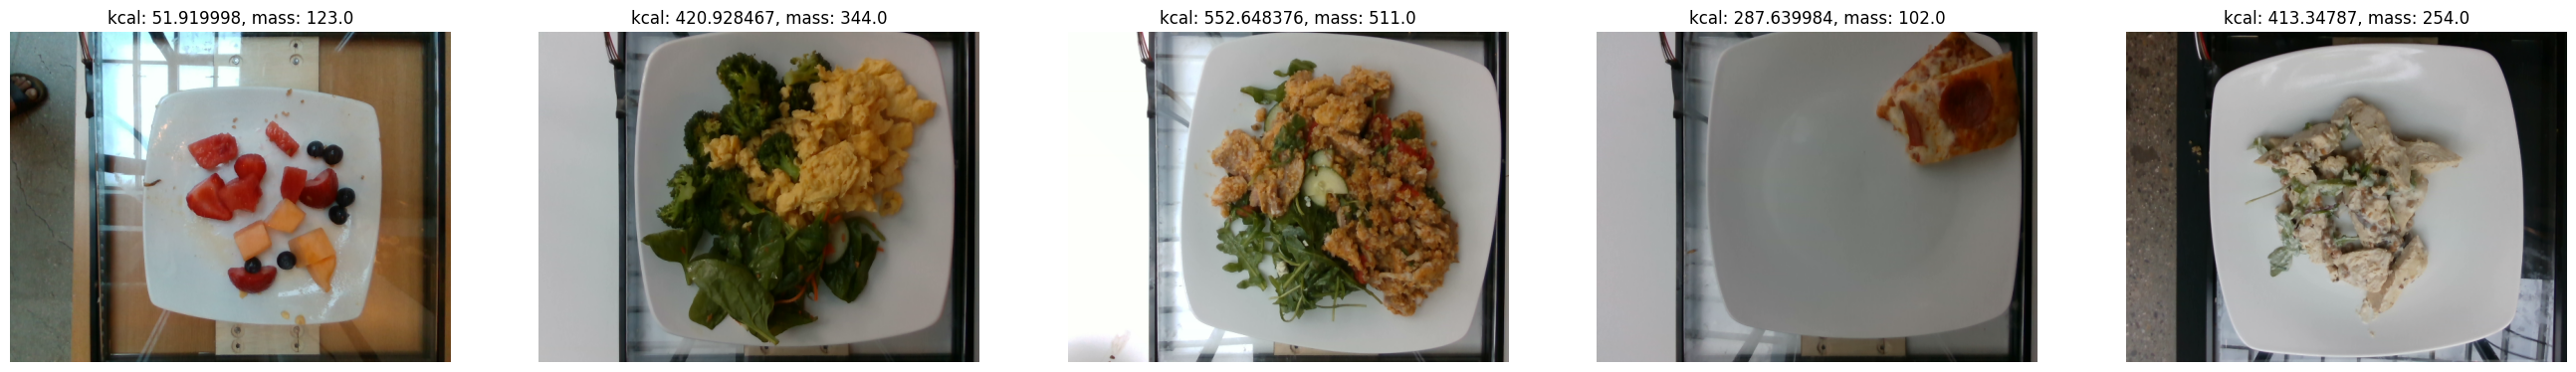

In [57]:
import matplotlib.pyplot as plt
from PIL import Image


sample = dish_df.sample(5)
dish_ids = sample['dish_id'].to_list()
calories = sample['total_calories'].to_list()
masses = sample['total_mass'].to_list()

fig = plt.figure(figsize=(40,20))
n = len(dish_ids)
for i in range(n):
    imgpath = os.path.join(data_folder, images_folder, dish_ids[i], 'rgb.png')
    image = Image.open(imgpath)
    plt.subplot(1, n+1, i+1)
    plt.imshow(image)
    plt.axis('off')
    kcal = calories[i]
    m = masses[i]
    plt.title(f'kcal: {kcal}, mass: {m}')

plt.show()

## Выбор архитектуры

Для текстовой части предлагаю взять distilbert: с его помощью можно получать неплохие эмбеддинги, но он в два раза меньше, чем bert-base-uncased.

Посмотрим, как называются у него слои, чтобы выбрать, какие из них разморозить.

In [40]:
from transformers import AutoModel


distilbert = AutoModel.from_pretrained('distilbert/distilbert-base-uncased')
for parameter in distilbert.named_parameters():
    print(parameter[0])

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
transformer.layer.0.attention.q_lin.weight
transformer.layer.0.attention.q_lin.bias
transformer.layer.0.attention.k_lin.weight
transformer.layer.0.attention.k_lin.bias
transformer.layer.0.attention.v_lin.weight
transformer.layer.0.attention.v_lin.bias
transformer.layer.0.attention.out_lin.weight
transformer.layer.0.attention.out_lin.bias
transformer.layer.0.sa_layer_norm.weight
transformer.layer.0.sa_layer_norm.bias
transformer.layer.0.ffn.lin1.weight
transformer.layer.0.ffn.lin1.bias
transformer.layer.0.ffn.lin2.weight
transformer.layer.0.ffn.lin2.bias
transformer.layer.0.output_layer_norm.weight
transformer.layer.0.output_layer_norm.bias
transformer.layer.1.attention.q_lin.weight
transformer.layer.1.attention.q_lin.bias
transformer.layer.1.attention.k_lin.weight
transformer.layer.1.attention.k_lin.bias
transformer.layer.1.attention.v_lin.weight
transformer.lay

Для изображений предлагаю взять маленькую efficientnet: хороший компромисс между производительностью и качеством. Для продуктов нужно находить нетривиальные фичи.

Посмотрим, как называются её слои. num_classes укажем 0, так как нам не нужен классификатор, а нужны только эмбеддинги.

In [38]:
import timm


imagemodel = timm.create_model("tf_efficientnetv2_s", pretrained=True, num_classes=0)
for parameter in imagemodel.named_parameters():
    print(parameter[0])

conv_stem.weight
bn1.weight
bn1.bias
blocks.0.0.conv.weight
blocks.0.0.bn1.weight
blocks.0.0.bn1.bias
blocks.0.1.conv.weight
blocks.0.1.bn1.weight
blocks.0.1.bn1.bias
blocks.1.0.conv_exp.weight
blocks.1.0.bn1.weight
blocks.1.0.bn1.bias
blocks.1.0.conv_pwl.weight
blocks.1.0.bn2.weight
blocks.1.0.bn2.bias
blocks.1.1.conv_exp.weight
blocks.1.1.bn1.weight
blocks.1.1.bn1.bias
blocks.1.1.conv_pwl.weight
blocks.1.1.bn2.weight
blocks.1.1.bn2.bias
blocks.1.2.conv_exp.weight
blocks.1.2.bn1.weight
blocks.1.2.bn1.bias
blocks.1.2.conv_pwl.weight
blocks.1.2.bn2.weight
blocks.1.2.bn2.bias
blocks.1.3.conv_exp.weight
blocks.1.3.bn1.weight
blocks.1.3.bn1.bias
blocks.1.3.conv_pwl.weight
blocks.1.3.bn2.weight
blocks.1.3.bn2.bias
blocks.2.0.conv_exp.weight
blocks.2.0.bn1.weight
blocks.2.0.bn1.bias
blocks.2.0.conv_pwl.weight
blocks.2.0.bn2.weight
blocks.2.0.bn2.bias
blocks.2.1.conv_exp.weight
blocks.2.1.bn1.weight
blocks.2.1.bn1.bias
blocks.2.1.conv_pwl.weight
blocks.2.1.bn2.weight
blocks.2.1.bn2.bias
block

Итак, у текстовой модели будем обучать последний трансформенный блок, а у модели для изображений — последний свёрточный блок и все следующие за ним.

## Итоговая конфигурация и обучение модели

Модель будет получать эмбеддинг для текста и для изображения, затем эмбеддинги будут приводиться к одному размеру и перемножаться. После этого следует блок регрессора, который возвращает одно число (предсказанные калории). Это число умножится на массу блюда — итоговое число и есть результат работы модели.

В качестве функции ошибки возьмём MSE, чтобы за большие отклонения штрафивать модель сильнее (часто людям важно знать калораж блюда как можно точнее). В качестве метрики для валидации и теста возьмём MAE, как более интерпретируемую. Сохранять будем модель с наименьшим MAE на валидации.

In [ ]:
from train_utils import train

import torch


class Config:
    SEED = 42

    TEXT_MODEL_NAME = "distilbert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnetv2_s"

    TEXT_MODEL_UNFREEZE = 'transformer.layer.5'
    IMAGE_MODEL_UNFREEZE = 'blocks.5|conv_head|bn2'

    LOSS = 'MSE'
    FUSION = 'concat'

    BATCH_SIZE = 16
    TEXT_LR = 3e-5
    IMAGE_LR = 1e-4
    REGRESSOR_LR = 1e-3
    EPOCHS = 10
    DROPOUT = 0.3
    HIDDEN_DIM = 256
    NUM_CLASSES = 4

    TRAIN_TEST_DF_PATH = "data/dish.csv"
    VOCAB_DF_PATH = "data/ingredients.csv"
    SAVE_PATH = "best_model.pth"


device = "cuda" if torch.cuda.is_available() else "cpu"
mse_concat_cfg = Config()

train(mse_concat_cfg, device)

c:\Users\admin\Documents\ML_Study\YandexPracticum\Sprint4_Tasks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1 train loss: 21131.3858
Val MAE: 80.0907
Epoch 2 train loss: 12221.6472
Val MAE: 63.0403
Epoch 3 train loss: 13827.8104
Val MAE: 58.0813
Epoch 4 train loss: 9457.3181
Val MAE: 49.1937
Epoch 5 train loss: 8340.2692
Val MAE: 47.5679
Epoch 6 train loss: 7216.8851
Val MAE: 47.2604
Epoch 7 train loss: 5778.3918
Val MAE: 41.8443
Epoch 8 train loss: 5474.9350
Val MAE: 41.9057
Epoch 9 train loss: 6283.9740
Val MAE: 48.4782
Epoch 10 train loss: 4970.7805
Val MAE: 36.4841
Test MAE after 10 epochs of train: 47.7574


In [1]:
from train_utils import train

import torch


class Config:
    SEED = 42

    TEXT_MODEL_NAME = "distilbert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnetv2_s"

    TEXT_MODEL_UNFREEZE = 'transformer.layer.5'
    IMAGE_MODEL_UNFREEZE = 'blocks.5|conv_head|bn2'

    LOSS = 'MSE'
    FUSION = 'concat'

    BATCH_SIZE = 16
    TEXT_LR = 3e-5
    IMAGE_LR = 1e-4
    REGRESSOR_LR = 1e-3
    EPOCHS = 10
    DROPOUT = 0.3
    HIDDEN_DIM = 256
    NUM_CLASSES = 4

    TRAIN_TEST_DF_PATH = "data/dish.csv"
    VOCAB_DF_PATH = "data/ingredients.csv"
    SAVE_PATH = "best_model.pth"


device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\admin\Documents\ML_Study\YandexPracticum\Sprint4_Tasks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Теперь попробуем различные LOSS-функции и разное объединение эмбеддингов

L1Loss вместо MSELoss:

In [2]:
mae_concat_cfg = Config()
mae_concat_cfg.LOSS = 'MAE'
train(mae_concat_cfg, device)

Epoch 1 train loss: 97.1919
Val MAE: 63.3567
Epoch 2 train loss: 70.1407
Val MAE: 59.7152
Epoch 3 train loss: 63.0997
Val MAE: 47.7046
Epoch 4 train loss: 58.0084
Val MAE: 45.3599
Epoch 5 train loss: 53.5578
Val MAE: 45.2270
Epoch 6 train loss: 48.5320
Val MAE: 47.7818
Epoch 7 train loss: 47.2399
Val MAE: 43.5420
Epoch 8 train loss: 44.3477
Val MAE: 39.6772
Epoch 9 train loss: 43.0694
Val MAE: 38.9857
Epoch 10 train loss: 39.0323
Val MAE: 35.2407
Test MAE after 10 epochs of train: 47.3248


Видно, что с L1Loss валидационные метрики снижались быстрее, и MAE на тестовом примере немного, но ниже.
Теперь попробуем поменять конкатенацию эмбеддингов на произведение:

In [ ]:
mae_mul_cfg = Config()
mae_mul_cfg.LOSS = 'MAE'
mae_mul_cfg.FUSION = 'mul'
train(mae_mul_cfg, device)

Epoch 1 train loss: 98.3137
Val MAE: 68.6436
Epoch 2 train loss: 73.0768
Val MAE: 56.7910
Epoch 3 train loss: 64.7537
Val MAE: 49.3920
Epoch 4 train loss: 56.8982
Val MAE: 43.3907
Epoch 5 train loss: 53.0110
Val MAE: 40.8813
Epoch 6 train loss: 47.5292
Val MAE: 38.4537
Epoch 7 train loss: 46.9489
Val MAE: 41.1663
Epoch 8 train loss: 43.6329
Val MAE: 42.1331
Epoch 9 train loss: 42.5431
Val MAE: 35.7810
Epoch 10 train loss: 39.6995
Val MAE: 35.7617
Test MAE after 10 epochs of train: 41.5387


Получили MAE на тесте ещё ниже.
Наконец, попробуем сумму эмбеддингов:

In [3]:
mae_sum_cfg = Config()
mae_sum_cfg.LOSS = 'MAE'
mae_sum_cfg.FUSION = 'sum'
train(mae_sum_cfg, device)

Epoch 1 train loss: 92.5703
Val MAE: 64.8071
Epoch 2 train loss: 71.1454
Val MAE: 69.6544
Epoch 3 train loss: 65.4415
Val MAE: 49.5398
Epoch 4 train loss: 55.6011
Val MAE: 49.6320
Epoch 5 train loss: 53.4781
Val MAE: 43.6330
Epoch 6 train loss: 46.9490
Val MAE: 38.7669
Epoch 7 train loss: 44.8079
Val MAE: 37.5332
Epoch 8 train loss: 43.1312
Val MAE: 36.8948
Epoch 9 train loss: 41.7627
Val MAE: 42.4069
Epoch 10 train loss: 39.6335
Val MAE: 35.4143
Test MAE after 10 epochs of train: 42.6181


## Итоги обучения

Итак, лучшие метрики получились у модели, которая обучалась с L1Loss и у которой эмбеддинги перемножались:
* Best val MAE: 35.7617
* Train MAE: 41.5387

### Инференс модели
Для тестовой выборки найдём самые ошибочные предсказания и визуализируем их.

In [14]:
from train_utils import test_model_inferece
from dataset import get_ingredients_dict, convert_to_recipe


_, ids, errors = test_model_inferece(mae_mul_cfg, device)

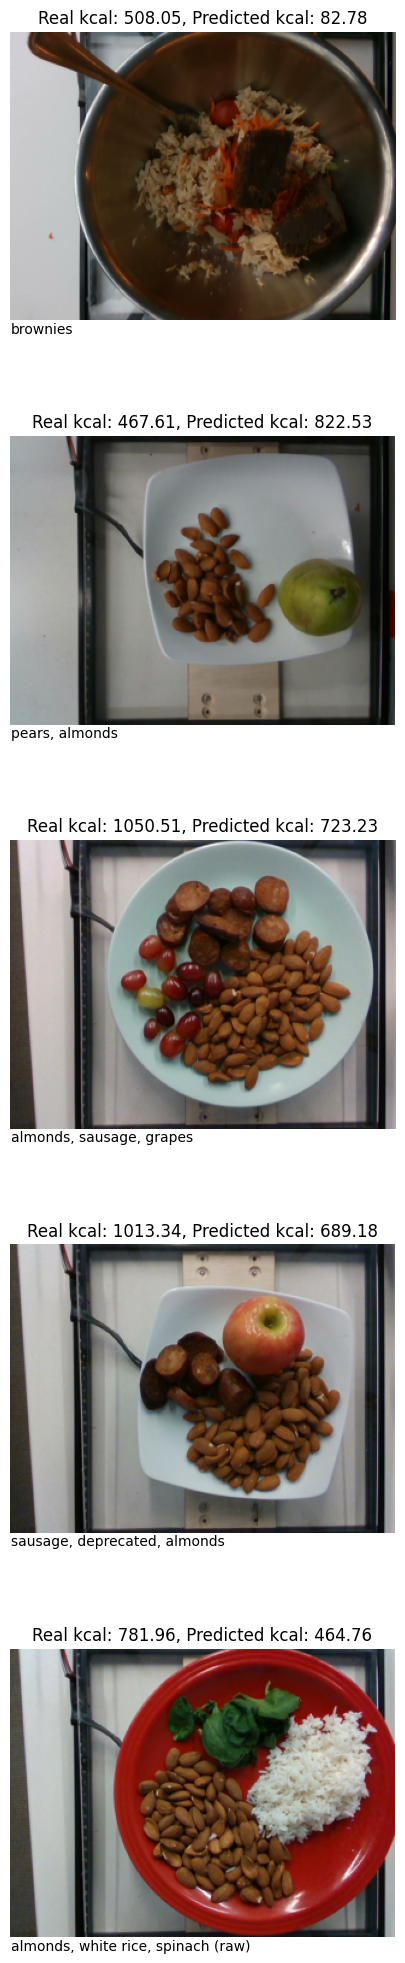

In [15]:
import matplotlib.pyplot as plt

import os

from PIL import Image


fig = plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.4)
n = len(ids)
ingredients_dict = get_ingredients_dict(mae_mul_cfg)

for i, (id, error) in enumerate(zip(ids, errors)):
    imgpath = os.path.join(data_folder, images_folder, id, 'rgb.png')
    image = Image.open(imgpath)
    size = (image.size[0] // 2, image.size[1] // 2)
    image = image.resize(size)
    
    row = dish_df[dish_df['dish_id'] == id]
    kcal = row['total_calories'].to_list()[0]
    ingrs = convert_to_recipe(';'.join(row['ingredients'].to_list()[0]), ingredients_dict)
    pred = error + kcal

    plt.subplot(n+1, 1, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Real kcal: {kcal:.2f}, Predicted kcal: {pred:.2f}')
    plt.text(0, size[1]+10, ingrs)

plt.show()

Можно увидеть следующие проблемы и особенности:
* На ошибочных сэмплах присутствуют тарелки другого цвета и формы. В датасете преобладали квадратные тарелки белого цвета. С одной стороны, можно было бы попробовать сделать более агрессивными трансформации, связанные с цветом. Но тогда и цвет ингредиентов мог бы исказиться, что повлияло бы на предсказания модели. 
* В одном из сэмплов вдобавок к уже описанным проблемам текстовое описание не соответствует тому, что изображено ("brownies", есть даже сэмпл с "deprecated").
* Почти во всех сэмплах присутствует миндаль. Возможно, это совпадение, так как миндаль есть на 10% тестовых примеров.

Как можно поступить:
* Перед обучением с помощью LLM или человека отсеять изображения с неподходящими подписями, или уточнить их.
* Расширить датасет, добавив в него больше посуды разных цветов. При этом цвет не должен коррелировать с калоражем: например, не стоит на один и тот же цвет всегда класть только низкокалорийные блюда.